### Initial setup

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, schedule, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import pandas as pd

import random

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal
from qiskit_experiments.library.calibration.frequency_cal import FrequencyCal
from qiskit_experiments.library.calibration.fine_frequency_cal import FineFrequencyCal

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit.tools.monitor import job_monitor

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

from qiskit import transpile, schedule as build_schedule, QuantumRegister, ClassicalRegister
from qiskit.pulse import Schedule, Play, SetFrequency, Drag, Gaussian, ShiftFrequency, GaussianSquare, DriveChannel, ControlChannel, Waveform, ScheduleBlock, Acquire, AcquireChannel, MemorySlot, MeasureChannel, Delay
from qiskit.circuit import QuantumRegister, ClassicalRegister, Parameter, Gate

from qiskit.circuit import Instruction

# based on https://stackoverflow.com/questions/49503869/attributeerror-while-trying-to-load-the-pickled-matplotlib-figure
def show_figure(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    
# based on https://www.delftstack.com/howto/python/parallel-for-loops-python/
import asyncio
import time

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

d = lambda idx: pulse.DriveChannel(idx)
m = lambda idx: pulse.MeasureChannel(idx)
u = lambda idx: pulse.ControlChannel(idx)
a = lambda idx: pulse.AcquireChannel(idx)

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# backend = provider.get_backend('ibmq_casablanca')
backend = provider.get_backend('ibmq_jakarta')
# backend = QasmSimulator.from_backend(backend)

config = backend.configuration() # configuration - Hardware configuration information.
properties = backend.properties() # properties - Physical properties of the device.
defaults = backend.defaults() # defaults - Information for pulse properties that change frequently.

from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_histogram

from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho, RZXCalibrationBuilder

from qiskit.circuit.library import XGate, YGate, SXGate, RZGate

from qiskit.visualization.pulse_v2 import draw, IQXDebugging

import time
from tqdm import tqdm_notebook as tqdm

from scipy.optimize import curve_fit
import copy

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### Utils

In [2]:
def display_gates_pulses(instructions, qubits, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            print(inst_map.get(instruction, qubit))

def update_drag_parameter(qubit, instruction, parameter, new_value, inst_map):
    old_sched = inst_map.pop(instruction, qubit)
    for instr_ in old_sched.instructions:
        if isinstance(instr_[1], pulse.instructions.play.Play):
            if isinstance(instr_[1].operands[0], pulse.Drag):
                duration = new_value if parameter == 'duration' else instr_[1].operands[0].duration
                amp = new_value if parameter == 'amp' else instr_[1].operands[0].amp
                sigma = new_value if parameter == 'sigma' else instr_[1].operands[0].sigma
                beta = new_value if parameter == 'beta' else instr_[1].operands[0].beta
                name = new_value if parameter == 'name' else instr_[1].operands[0].name
    # new_sched = SetFrequency(qubit_freq_cal[qubit], d(qubit)) + Play(Drag(duration, amp, sigma, beta, name), d(qubit))
    new_sched = Schedule()
    # new_sched = ShiftFrequency(0, d(qubit)) + Play(Drag(duration, amp, sigma, beta, name), d(qubit))
    new_sched += Play(Drag(duration, amp, sigma, beta, name), d(qubit))    
    inst_map.add(instruction, qubit, new_sched)
    
def update_cal_from_inst_map(qubits, instructions, cal, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            sched = inst_map.get(instruction, qubit)
            for instr_ in sched.instructions:
                if isinstance(instr_[1], pulse.instructions.play.Play):
                    if isinstance(instr_[1].operands[0], pulse.Drag):
                        duration = instr_[1].operands[0].duration
                        amp = instr_[1].operands[0].amp
                        sigma = instr_[1].operands[0].sigma
                        beta = instr_[1].operands[0].beta
                        name = instr_[1].operands[0].name
                        # print(qubit, instruction, ":", duration, amp, sigma, beta)
                        cal.add_parameter_value(amp, 'amp', qubit, instruction)
                        cal.add_parameter_value(duration, 'duration', qubit, instruction)
                        cal.add_parameter_value(sigma, 'σ', qubit, instruction)
                        cal.add_parameter_value(beta, 'β', qubit, instruction)    
    
def update_inst_map_from_cal(qubits, instructions, cal, inst_map):
    for qubit in qubits:
        for instruction in instructions:
            update_drag_parameter(qubit, instruction, 'amp', cal.get_parameter_value('amp', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'beta', cal.get_parameter_value('β', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'sigma', cal.get_parameter_value('σ', qubit, instruction), inst_map)
            update_drag_parameter(qubit, instruction, 'duration', cal.get_parameter_value('duration', qubit, instruction), inst_map)


### Setup

In [3]:
qubits = [0, 1, 2, 3, 4, 5, 6]

duration = 10*16

inst_map_cal = pulse.InstructionScheduleMap() # instruction map with tunned ibm calibration settings
inst_map_ncal = pulse.InstructionScheduleMap() # instruction map with default ibm calibration settings

for instruction in defaults.instruction_schedule_map.instructions:
    if instruction not in  ['cx', 'u1', 'u2', 'u3']:
        for qubit in qubits:
            inst_map_cal.add(instruction, qubit, defaults.instruction_schedule_map.get(instruction, qubit))
            inst_map_ncal.add(instruction, qubit, defaults.instruction_schedule_map.get(instruction, qubit))
            
inst_map_cal.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))
inst_map_ncal.add('measure', range(config.n_qubits), 
             defaults.instruction_schedule_map.get('measure', range(config.n_qubits)))

cx_qubits = [(1,3), (3,1), (3,5), (5, 3)]
for qubit in cx_qubits:
    inst_map_cal.add('cx', qubit, defaults.instruction_schedule_map.get('cx', qubit))
    inst_map_ncal.add('cx', qubit, defaults.instruction_schedule_map.get('cx', qubit))

for instruction in ['sx','x']:
    for qubit in qubits:
        update_drag_parameter(qubit, instruction, 'duration', duration, inst_map_cal)

### Gates Fine tunning

#### Create calibration

##### TODO frequency cal?

##### Amplitude calibration

In [5]:
import os
def save_calibration(cals):
    timestr = time.strftime("%Y%m%d-%H%M%S")
    
    if not os.path.exists("./gates_calibration"):
        os.makedirs("./gates_calibration")
        
    calibration_dir = "./gates_calibration/" + timestr
    if not os.path.exists(calibration_dir):
        os.makedirs(calibration_dir)
    cals.save(folder=calibration_dir)

In [6]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitudeCal, FineSXAmplitudeCal

library = FixedFrequencyTransmon(default_values={"duration": duration})
dummy_cals = Calibrations.from_backend(backend, library)
update_cal_from_inst_map(qubits, ['sx','x'], dummy_cals, inst_map_cal)

jobs_data_amp_x = []
jobs_data_amp_sx = []

def FineAmplitudeCal_(qubit, x_repetitions=None, sx_repetitions=None):
    FineXAmplitudeCal_(qubit, repetitions=x_repetitions)
    save_calibration(dummy_cals)
    FineSXAmplitudeCal_(qubit, repetitions=sx_repetitions)
    save_calibration(dummy_cals)

def FineXAmplitudeCal_(qubit, repetitions=None):
    amp_x_cal = FineXAmplitudeCal(qubit, dummy_cals, backend=backend, schedule_name='x')
    print("FineXAmplitudeCal", qubit, repetitions)
    if repetitions is not None:
        amp_x_cal.set_experiment_options(repetitions=repetitions)
    job_data_x = amp_x_cal.run().block_for_results()
    jobs_data_amp_x.append(job_data_x)

def FineSXAmplitudeCal_(qubit, repetitions=None):
    amp_sx_cal = FineSXAmplitudeCal(qubit, dummy_cals, backend=backend, schedule_name='sx')
    print("FineSXAmplitudeCal", qubit, repetitions)
    if repetitions is not None:
        amp_sx_cal.set_experiment_options(repetitions=repetitions)
    job_data_sx = amp_sx_cal.run().block_for_results()
    jobs_data_amp_sx.append(job_data_sx)

##### Drag calibration

In [7]:
from qiskit_experiments.library import FineXDragCal, FineSXDragCal

jobs_data_drag_x = []
jobs_data_drag_sx = []

def FineDragCal_(qubit, repetitions=None):
    FineXDragCal_(qubit, repetitions)
    save_calibration(dummy_cals)
    FineSXDragCal_(qubit, repetitions)
    save_calibration(dummy_cals)

def FineXDragCal_(qubit, repetitions=None):
    drag_data = FineXDragCal(qubit, dummy_cals, backend=backend)
    print("FineXDragCal", qubit, repetitions)
    if repetitions is not None:
        drag_data.set_experiment_options(repetitions=repetitions)
    job_data = drag_data.run().block_for_results()
    jobs_data_drag_x.append(job_data)
    
def FineSXDragCal_(qubit, repetitions=None):
    drag_data = FineSXDragCal(qubit, dummy_cals, backend=backend)
    print("FineSXDragCal", qubit, repetitions)
    if repetitions is not None:
        drag_data.set_experiment_options(repetitions=repetitions)
    job_data = drag_data.run().block_for_results()
    jobs_data_drag_sx.append(job_data)

##### Run

In [8]:
for qubit in [1,3,5]:
    FineAmplitudeCal_(qubit)
    FineDragCal_(qubit)
    
for qubit in [1,3,5]:
    FineAmplitudeCal_(qubit, x_repetitions=list(range(0,100)), sx_repetitions=[0, 1, 2]+list(range(3,100,2)))
    FineDragCal_(qubit, repetitions=list(range(0,50)))

del jobs_data_amp_x
del jobs_data_amp_sx
del jobs_data_drag_x
del jobs_data_drag_sx

update_inst_map_from_cal(qubits, ['sx','x'], dummy_cals, inst_map_cal)

FineXAmplitudeCal 1 None


KeyboardInterrupt: 

In [9]:
save_calibration(dummy_cals)

In [12]:
display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_ncal)
print("")
display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_cal)

Schedule((0, Play(Drag(duration=160, amp=(0.19271449272551472+0j), sigma=40, beta=-1.009747892006602, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09659868697763228+0.0019938014812651054j), sigma=40, beta=-1.1626383003073515, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), name="sx")
Schedule((0, Play(Drag(duration=160, amp=(0.1940528505068141+0j), sigma=40, beta=0.5858879259509526, name='Xp_d3'), DriveChannel(3), name='Xp_d3')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09699111227786138-0.00014683684688283845j), sigma=40, beta=0.570582078191895, name='X90p_d3'), DriveChannel(3), name='X90p_d3')), name="sx")
Schedule((0, Play(Drag(duration=160, amp=(0.1881920502989176+0j), sigma=40, beta=-0.8402115417755494, name='Xp_d5'), DriveChannel(5), name='Xp_d5')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09403503336510041+0.0013687694014715578j), sigma=40, beta=-0.8143307075563275, name='X90p_d5'), DriveChann

#### Restore calibration

In [4]:
RESTORE_CALIBRATION = True
calibration_dir = "./gates_calibration/20220320-002545"
if RESTORE_CALIBRATION:
    library = FixedFrequencyTransmon(default_values={"duration": duration})
    dummy_cals = Calibrations.from_backend(backend, library)
    dummy_cals.load_parameter_values(calibration_dir + "/parameter_values.csv")

    print("values before calibration:\n")
    display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_ncal)
    update_inst_map_from_cal(qubits, ['sx','x'], dummy_cals, inst_map_cal)
    print("\nvalues after calibration:\n")
    display_gates_pulses(['x', 'sx'], [1, 3, 5], inst_map_cal)

values before calibration:

Schedule((0, Play(Drag(duration=160, amp=(0.191987417301026+0j), sigma=40, beta=-1.0154238689604123, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09602351197903138+0.0020668738128796866j), sigma=40, beta=-1.062216744995086, name='X90p_d1'), DriveChannel(1), name='X90p_d1')), name="sx")
Schedule((0, Play(Drag(duration=160, amp=(0.19367639565362346+0j), sigma=40, beta=0.594855031154797, name='Xp_d3'), DriveChannel(3), name='Xp_d3')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.0967976260147028-0.00021956473635572894j), sigma=40, beta=0.6452264376958543, name='X90p_d3'), DriveChannel(3), name='X90p_d3')), name="sx")
Schedule((0, Play(Drag(duration=160, amp=(0.1873025084389293+0j), sigma=40, beta=-0.8555630962408309, name='Xp_d5'), DriveChannel(5), name='Xp_d5')), name="x")
Schedule((0, Play(Drag(duration=160, amp=(0.09360757213207338+0.0013114923408934674j), sigma=40, beta=-0.8213921090071457, n

### Custom discriminator

In [4]:
def measurement_circuit(qubits, final_state, delay=None):
    qc = QuantumCircuit(backend.configuration().n_qubits, len(qubits))
    if final_state == 'ext':
        qc.x(qubits)
    if delay is not None:
        qc.delay(delay, qubits)
    qc.measure(qubits, list(range(len(qubits))))
    return qc

from qiskit.ignis.measurement import SklearnIQDiscriminator

def add_measurement_cal(schedule_qc, amp_mul=None, discriminators=None):
    if amp_mul is None:
        measurement_amp_mult = [1.6, 2.8, 2.8, 2.4, 2.8, 2.8, 1.2]
    else:
        measurement_amp_mult = [amp_mul]*7
        
    if discriminators is not None:
        measurement_amp_mult = []
        for discr in discriminators:
            measurement_amp_mult.append(discr['settings']['amp_mul'])
    
    schedule_qc_ = []
    pbar = tqdm(total=len(schedule_qc))
    for sched_ in schedule_qc:
        new_sched_ = Schedule.initialize_from(sched_)
        for time, inst in sched_.children:
            if isinstance(inst.channels[0], AcquireChannel):
                # print(inst.children)
                new_acquire_sched_ = Schedule()
                for time_, inst_ in inst.children[1][1].children:
                # for time_, inst_ in inst.children:
                    if isinstance(inst_.channels[0], MeasureChannel) and isinstance(inst_, pulse.instructions.play.Play):
                        new_acquire_sched_.insert(time_, Play(GaussianSquare(duration=inst_.operands[0].duration, 
                                                                            amp=inst_.operands[0].amp * measurement_amp_mult[inst_.channel.index], # <-----
                                                                            sigma=inst_.operands[0].sigma, 
                                                                            width=inst_.operands[0].width, 
                                                                            name=inst_.operands[0].name), 
                                                             MeasureChannel(inst_.channel.index), name=inst_.name), inplace=True)
                    else:
                        if isinstance(inst_, Acquire):
                            aq_idx = inst_.channels[0].index
                            if discriminators is not None:
                                if discriminators[aq_idx] is not None:
                                    discriminator = discriminators[aq_idx]['discriminator']
                                    discriminator.name = "quadratic_discriminator"
                                    discriminator.params = {}
                                    new_acquire_sched_.insert(time_, Acquire(inst_.operands[0], AcquireChannel(aq_idx), MemorySlot(inst_.operands[2].index), discriminator=discriminator), inplace=True)
                                else:
                                    new_acquire_sched_.insert(time_, inst_, inplace=True)
                            else:
                                new_acquire_sched_.insert(time_, inst_, inplace=True)
                        else:
                            new_acquire_sched_.insert(time_, inst_, inplace=True)
                new_sched_.insert(time, new_acquire_sched_, inplace=True)
                
            else:
                new_sched_.insert(time, inst, inplace=True)
        schedule_qc_.append(new_sched_)
        pbar.update(1)
    pbar.close()
    return schedule_qc_

In [14]:
jobs_discriminator = []
circuits_discriminator = []
schedules_discriminator = []

experiments = [
    {'amp_mul': 1.0, 'qubits': qubits},
    {'amp_mul': 1.2, 'qubits': qubits},
    {'amp_mul': 1.4, 'qubits': qubits},
    {'amp_mul': 1.6, 'qubits': qubits},
    {'amp_mul': 1.8, 'qubits': qubits},
    {'amp_mul': 2.0, 'qubits': qubits},
    {'amp_mul': 2.2, 'qubits': qubits},
    {'amp_mul': 2.4, 'qubits': qubits},
    {'amp_mul': 2.6, 'qubits': qubits},
    {'amp_mul': 2.8, 'qubits': qubits},
    {'amp_mul': 3.0, 'qubits': qubits},
]

for exp in experiments:
    qc_gnd = measurement_circuit(exp['qubits'], final_state='gnd', delay=0)
    qc_ext = measurement_circuit(exp['qubits'], final_state='ext', delay=0)
    
    schedule_gnd = build_schedule(qc_gnd, backend, inst_map=inst_map_cal, method='alap')
    schedule_gnd = add_measurement_cal([schedule_gnd], amp_mul=exp['amp_mul'])[0]
    
    schedule_ext = build_schedule(qc_ext, backend, inst_map=inst_map_cal, method='alap')
    schedule_ext = add_measurement_cal([schedule_ext], amp_mul=exp['amp_mul'])[0]

    job = execute([schedule_gnd, schedule_ext], backend, meas_level=1, meas_return='single', memory=True, shots=32000, optimization_level=0) #, default_meas_los=meas_los_freq)
    job.wait_for_final_state()
    circuits_discriminator.append([qc_gnd, qc_ext])
    schedules_discriminator.append([schedule_gnd, schedule_ext]*4)
    job_monitor(job)
    jobs_discriminator.append(job)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt



In [15]:
timestr = time.strftime("%Y%m%d-%H%M%S")

jobs_discriminator = []
schedules_discriminator = []

# experiments = [
#     {'duration': 22400, 'amp_mul': 1.0, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 1.2, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 1.4, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 1.6, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 1.8, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 2.0, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 2.2, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 2.4, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 2.6, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 2.8, 'qubits': qubits},
#     {'duration': 22400, 'amp_mul': 3.0, 'qubits': qubits},
# ]

experiments = [{'duration': 22400, 'amp_mul': amp, 'qubits': qubits} for amp in np.linspace(1.0, 3.0, 11)]

for exp in experiments:
    qc_gnd = measurement_circuit(exp['qubits'], final_state='gnd', delay=0)
    qc_ext = measurement_circuit(exp['qubits'], final_state='ext', delay=0)
    
    schedule_gnd = build_schedule(qc_gnd, backend, inst_map=inst_map_cal, method='alap')
    schedule_gnd = add_measurement_cal([schedule_gnd], amp_mul=exp['amp_mul'])[0]
    
    schedule_ext = build_schedule(qc_ext, backend, inst_map=inst_map_cal, method='alap')
    schedule_ext = add_measurement_cal([schedule_ext], amp_mul=exp['amp_mul'])[0]
    
    schedules_discriminator.append(schedule_gnd)
    schedules_discriminator.append(schedule_ext)
    
job = execute(schedules_discriminator, backend, meas_level=1, meas_return='single', memory=True, shots=32000, optimization_level=0) #, default_meas_los=meas_los_freq)
print(str(job.job_id()) + "\t" + str(experiments) + "\n")
if not os.path.exists("./benchmarks"):
    os.makedirs("./benchmarks")
with open("./benchmarks/" + "MeasCal_Jackarta_real_benchmark" + timestr + ".tsv", 'a+') as f:
    f.write(str(job.job_id()) + "\t" + str(experiments) + "\n")
# job.wait_for_final_state()
# job_monitor(job)
# jobs_discriminator.append(job)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

623640850af65d5ee6d91f23	[{'duration': 22400, 'amp_mul': 1.0, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 1.2, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 1.4, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 1.6, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 1.8, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 2.0, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 2.2, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 2.4000000000000004, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 2.6, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 2.8, 'qubits': [0, 1, 2, 3, 4, 5, 6]}, {'duration': 22400, 'amp_mul': 3.0, 'qubits': [0, 1, 2, 3, 4, 5, 6]}]



Qubit:  0
Qubit:  1
Qubit:  2
Qubit:  3
Qubit:  4
Qubit:  5
Qubit:  6
0 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2aeab20>, 'score': 0.98240625, 'settings': {'duration': 22400, 'amp_mul': 2.2, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
1 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2cfcc40>, 'score': 0.979765625, 'settings': {'duration': 22400, 'amp_mul': 1.6, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
2 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2cfc310>, 'score': 0.98909375, 'settings': {'duration': 22400, 'amp_mul': 2.4, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
3 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7f03a2cfc070>, 'score': 0.983, 'settings': {'duration': 22400, 'amp_mul': 1.6, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
4 {'discri

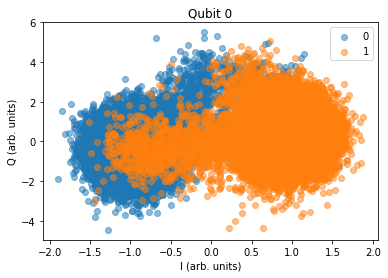

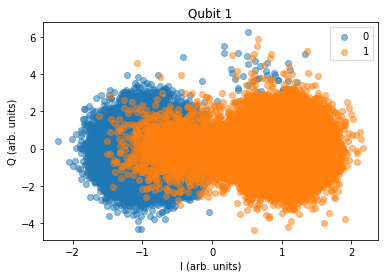

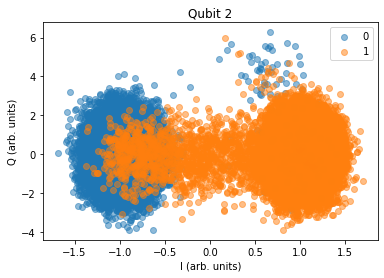

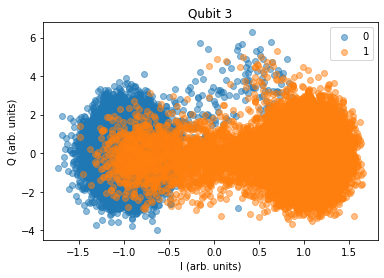

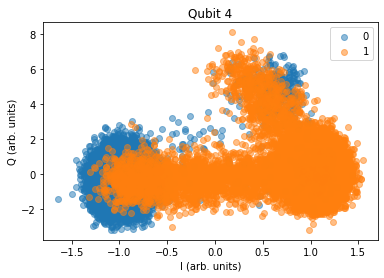

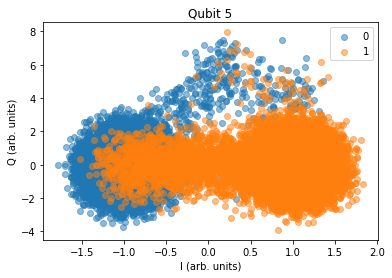

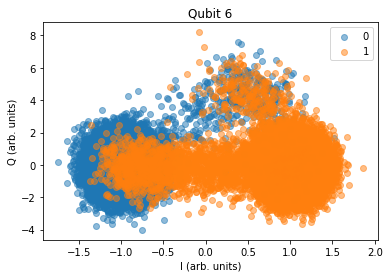

In [15]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from qiskit.ignis.measurement import SklearnIQDiscriminator, QuadraticIQDiscriminator

discriminators = []
display_fig = False
scale_factor = 1e-14

for qubit_idx in qubits:
    print("Qubit: ", qubits[qubit_idx])

    best_score = 0
    best_settings = None
    discriminator = None

    for job_idx, job in enumerate(jobs_discriminator):
        gnd_results = job.result().get_memory(0)[:, qubit_idx]*scale_factor
        exc_results = job.result().get_memory(1)[:, qubit_idx]*scale_factor
        # for circ_idx in range(1,4):
        #     gnd_results = np.concatenate([gnd_results, job.result().get_memory(circ_idx*2 + 0)[:, qubit_idx]*scale_factor])
        #     exc_results = np.concatenate([exc_results, job.result().get_memory(circ_idx*2 + 1)[:, qubit_idx]*scale_factor])

        gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
        exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])

        x = np.concatenate([gnd_results, exc_results])
        y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
        
        classifier = KNeighborsClassifier(100)
        classifier.fit(x,y)
        score = classifier.score(x, y)

        if score > best_score:
            if display_fig:
                plt.figure()
                fig, axs = plt.subplots(1, 2, figsize=(10, 10))
                axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[0].axis('square')

                axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[1].axis('square')

                x_min, x_max = x[:, 0].min(), x[:, 0].max()
                y_min, y_max = x[:, 1].min(), x[:, 1].max()
                xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))

                if hasattr(classifier, "decision_function"):
                    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
                else:
                    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                Z = Z.reshape(xx.shape)
                axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                plt.show()
        
            best_score = score
            best_settings = experiments[job_idx]
            discriminator = SklearnIQDiscriminator(KNeighborsClassifier(100), job.result(), [qubit_idx], expected_states=[0,1], standardize=True, schedules=schedules_discriminator[job_idx][:2])

    discriminators.append({'discriminator': discriminator, 'score': best_score, 'settings': best_settings})
    
for qubit in qubits:
    discriminators[qubit]['discriminator'].plot()
    print(qubit, discriminators[qubit])
    
import pickle
timestr = time.strftime("%Y%m%d-%H%M%S")
if not os.path.exists("./discriminators"):
    os.makedirs("./discriminators")
pickle.dump(discriminators, open("./discriminators/discriminators_" + timestr + ".pickle", "wb"))

# del jobs_discriminator
# del schedules_discriminator

In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from qiskit.ignis.measurement import SklearnIQDiscriminator, QuadraticIQDiscriminator

discriminators = []
display_fig = False
scale_factor = 1e-14

for qubit_idx in qubits:
    print("Qubit: ", qubits[qubit_idx])

    best_score = 0
    best_settings = None
    discriminator = None

    for exp_idx, exp in enumerate(experiments):
        # gnd_results = job.result().get_memory(0)[:, qubit_idx]*scale_factor #?
        # exc_results = job.result().get_memory(1)[:, qubit_idx]*scale_factor # ?

        gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
        exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])

        x = np.concatenate([gnd_results, exc_results])
        y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
        
        classifier = KNeighborsClassifier(100)
        classifier.fit(x,y)
        score = classifier.score(x, y)

        if score > best_score:
            if display_fig:
                plt.figure()
                fig, axs = plt.subplots(1, 2, figsize=(10, 10))
                axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[0].axis('square')

                axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[1].axis('square')

                x_min, x_max = x[:, 0].min(), x[:, 0].max()
                y_min, y_max = x[:, 1].min(), x[:, 1].max()
                xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))

                if hasattr(classifier, "decision_function"):
                    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
                else:
                    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                Z = Z.reshape(xx.shape)
                axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                plt.show()
        
            best_score = score
            best_settings = exp
            discriminator = SklearnIQDiscriminator(KNeighborsClassifier(100), job.result(), [qubit_idx], expected_states=[0,1], standardize=True, schedules=schedules_discriminator[exp_idx*2:exp_idx*2+1])

    discriminators.append({'discriminator': discriminator, 'score': best_score, 'settings': best_settings})
    
for qubit in qubits:
    discriminators[qubit]['discriminator'].plot()
    print(qubit, discriminators[qubit])
    
import pickle
timestr = time.strftime("%Y%m%d-%H%M%S")
if not os.path.exists("./discriminators"):
    os.makedirs("./discriminators")
pickle.dump(discriminators, open("./discriminators/discriminators_" + timestr + ".pickle", "wb"))

del jobs_discriminator
del schedules_discriminator

In [30]:
import pickle
RESTORE_DISCRIMINATORS = True
if RESTORE_DISCRIMINATORS:
    discriminators = pickle.load(open( "./discriminators/discriminators_20220320-012047.pickle", "rb"))

### Ising model

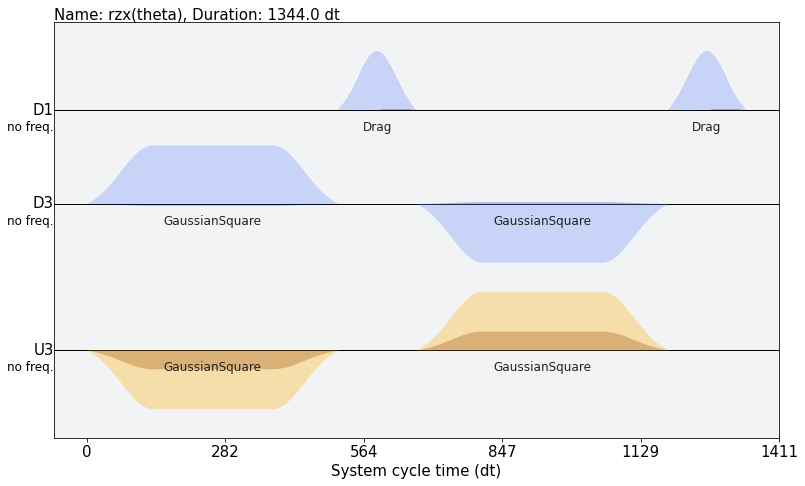

In [5]:
RzxCal = RZXCalibrationBuilder(backend=backend, instruction_schedule_map=inst_map_cal)
RzxCalNoEcho = RZXCalibrationBuilderNoEcho(backend=backend, instruction_schedule_map=inst_map_cal)

def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def rzx_cal(qubits, theta, amp_mul=1.0, amp=None, amp_t=None, duration=None, sigma=None, x_cal=False, waveform=None):
    theta_ = Instruction('theta', 7, 7, params=[theta])
    def_rzx_cal = RzxCal.get_calibration(theta_, qubits)
    # show_figure(def_rzx_cal.draw(style=IQXDebugging()))
    
    amp_dr_, amp_ctr_, sigma_, width_, duration_, ctr_ch_, dr_ch_ = None, None, None, None, None, None, None
    x_amp_, x_beta_, x_sigma_, x_duration_, x_dr_ch_ = None, None, None, None, None
    for instr_ in def_rzx_cal.instructions:
        
        if isinstance(instr_[1], pulse.instructions.play.Play):
            if isinstance(instr_[1].operands[0], pulse.GaussianSquare):
                if isinstance(instr_[1].channel, pulse.channels.ControlChannel):
                    # CR control
                    if amp_ctr_ is None:
                        # print(instr_[1].operands[0])
                        amp_ctr_ = instr_[1].operands[0].amp
                        ctr_ch_ = instr_[1].channel.index
                else:
                    #CR drive
                    if amp_dr_ is None:
                        # print(instr_[1].operands[0])
                        amp_dr_ = instr_[1].operands[0].amp
                        sigma_ = instr_[1].operands[0].sigma
                        duration_ = instr_[1].operands[0].duration
                        width_ = instr_[1].operands[0].width
                        dr_ch_ = instr_[1].channel.index
            if isinstance(instr_[1].operands[0], pulse.Drag):
                # X pulses
                if x_amp_ is None:
                    # print(instr_[1].operands[0])
                    x_duration_ = instr_[1].operands[0].duration
                    x_amp_ = instr_[1].operands[0].amp
                    x_beta_ = instr_[1].operands[0].beta
                    x_dr_ch_ = instr_[1].channel.index
                    x_sigma_ = instr_[1].operands[0].sigma
                    
    if amp is not None:
        if amp[0] is not None:
            amp_ctr_ = amp[0]+amp_ctr_.imag*1j
        if amp[1] is not None:
            amp_ctr_ = amp_ctr_.real+amp[1]
            
    if amp_t is not None:
        if amp_t[0] is not None:
            amp_dr_ = amp_t[0]+amp_dr_.imag*1j
        if amp_t[1] is not None:
            amp_dr_ = amp_dr_.real+amp_t[1]
                       
    if duration is not None:
        duration = get_closest_multiple_of_16(duration)
        width_ = duration/duration_ * width_
        duration_ = duration
        
    if sigma is not None:
        sigma_ = sigma
        
    if x_cal:
        x_cal = inst_map_cal.get('x', x_dr_ch_)
        x_amp_, x_beta_, x_sigma_, x_duration_ = x_cal.instructions[0][1].operands[0].amp, x_cal.instructions[0][1].operands[0].beta, \
                                                 x_cal.instructions[0][1].operands[0].sigma, x_cal.instructions[0][1].operands[0].duration
        
    amp_ctr_ *= amp_mul
    amp_dr_ *= amp_mul

    # print("duration:", duration_)
    # print("amp_ctr_:", amp_ctr_)
    # print("amp_dr_:", amp_dr_)

    if waveform is None:
        rzx_cal = Schedule((0, Play(GaussianSquare(duration=duration_, amp=amp_dr_, sigma=sigma_, width=width_), DriveChannel(dr_ch_))),
                       (0, Play(GaussianSquare(duration=duration_, amp=amp_ctr_, sigma=sigma_, width=width_), ControlChannel(ctr_ch_))),
                       (duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       (duration_+x_duration_, Play(GaussianSquare(duration=duration_, amp=-amp_dr_, sigma=sigma_, width=width_), DriveChannel(dr_ch_))),
                       (duration_+x_duration_, Play(GaussianSquare(duration=duration_, amp=-amp_ctr_, sigma=sigma_, width=width_), ControlChannel(ctr_ch_))),
                       (2*duration_+x_duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       name="rzx(theta)")
    else:
        rzx_cal = Schedule((0, Play(Waveform(waveform), ControlChannel(ctr_ch_))),
                       (duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       (duration_+x_duration_, Play(Waveform([-x for x in waveform]), ControlChannel(ctr_ch_))),
                       (2*duration_+x_duration_, Play(Drag(duration=x_duration_, amp=x_amp_, sigma=x_sigma_, beta=x_beta_), DriveChannel(x_dr_ch_), name='Xp_d5')),
                       name="rzx(theta)")
        
    return rzx_cal

rzx_cal((1,3), 2*np.pi/6, amp_mul=1.0, duration=None, x_cal=True, waveform=None).draw()

In [13]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

def ising_sim(trotter_steps, target_time, optimization_level, circ_type, 
              calibrated=False, zne_pattern=[], add_resets=False):
    q0 = 1
    q1 = 3
    q2 = 5
    
    num_qubits = 3
    
    Ising2Q_qr = QuantumRegister(2)
    Ising2Q_qc = QuantumCircuit(Ising2Q_qr, name='Ising_2Qubits')
    
    if circ_type == 'cnot':
        t = Parameter('t')
        
        Ising2Q_qc.cnot(0,1)
        Ising2Q_qc.rx(2 * t - np.pi/2, 0)
        Ising2Q_qc.h(0)
        Ising2Q_qc.rz(2 * t, 1)
        Ising2Q_qc.cnot(0,1)
        Ising2Q_qc.h(0)
        Ising2Q_qc.rz(-2 * t, 1) # dagger
        Ising2Q_qc.cnot(0,1)
        Ising2Q_qc.rx(np.pi/2,0)
        Ising2Q_qc.rx(-np.pi/2,1) # dagger
    if circ_type == 'rzx':
        rzx_gate = Gate('rzx_', 2, [])
        
        Ising2Q_qc.rz(np.pi/2, 0)
        Ising2Q_qc.sx(0)
        Ising2Q_qc.rz(-np.pi/2, 0)

        Ising2Q_qc.append(rzx_gate, [0, 1])
        Ising2Q_qc.sx(0)
        Ising2Q_qc.rz(-np.pi/2, 0) # Sdg
        Ising2Q_qc.rz(-np.pi/2, 1) # Sdg

        Ising2Q_qc.append(rzx_gate, [0, 1])
        Ising2Q_qc.sx(0)
        Ising2Q_qc.rz(-np.pi, 0)
        Ising2Q_qc.rz(-np.pi, 1)
        Ising2Q_qc.sx(1)
        Ising2Q_qc.rz(np.pi/2, 1)

        Ising2Q_qc.append(rzx_gate, [0, 1])
        Ising2Q_qc.h(1)
        
    Ising2Q = Ising2Q_qc.to_instruction()
    
    if len(zne_pattern) != 0:
        Ising2Q_inv_qr = QuantumRegister(2)
        Ising2Q_inv_qc = QuantumCircuit(Ising2Q_qr, name='Ising_inv_2Qubits')

        if circ_type == 'cnot':
            Ising2Q_inv_qc.rx(-np.pi/2,0)
            Ising2Q_inv_qc.rx(np.pi/2,1) # dagger
            Ising2Q_inv_qc.cnot(0,1)
            Ising2Q_inv_qc.h(0)
            Ising2Q_inv_qc.rz(2 * t, 1) # dagger
            Ising2Q_inv_qc.cnot(0,1)
            Ising2Q_inv_qc.h(0)
            Ising2Q_inv_qc.rz(-2 * t, 1)
            Ising2Q_inv_qc.rx(-2 * t + np.pi/2, 0)
            Ising2Q_inv_qc.cnot(0,1)
            
        if circ_type == 'rzx':
            rzx_inv_gate = Gate('rzx_inv_', 2, [])
            
            Ising2Q_inv_qc.h(1)
            Ising2Q_inv_qc.append(rzx_inv_gate, [0, 1])
            
            Ising2Q_inv_qc.sx(0)
            Ising2Q_inv_qc.rz(-np.pi, 0)
            Ising2Q_inv_qc.rz(np.pi/2, 1)
            Ising2Q_inv_qc.sx(1)

            Ising2Q_inv_qc.append(rzx_inv_gate, [0, 1])
            
            Ising2Q_inv_qc.rz(-np.pi/2, 0)
            Ising2Q_inv_qc.sx(0)
            Ising2Q_inv_qc.rz(-np.pi, 0)
            Ising2Q_inv_qc.rz(np.pi/2, 1)

            Ising2Q_inv_qc.append(rzx_inv_gate, [0, 1])
            Ising2Q_inv_qc.rz(-np.pi/2, 0)
            Ising2Q_inv_qc.sx(0)
            Ising2Q_inv_qc.rz(np.pi/2, 0)
            
        Ising2Q_inv = Ising2Q_inv_qc.to_instruction()
    
    qc = QuantumCircuit(7)
    
    # if add_resets:
    #     qc.reset(q0)
    
    qc.x([q1,q2])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    for step in range(trotter_steps):
        qc.append(Ising2Q, [q0, q1])       
        if len(zne_pattern) > step:
            for _ in range(2, int(zne_pattern[step][0])+1):
                qc.append(Ising2Q_inv, [q0, q1])
                qc.append(Ising2Q, [q0, q1])
                
        qc.append(Ising2Q, [q1, q2])
        if len(zne_pattern) > step:
            for _ in range(2, int(zne_pattern[step][1])+1):
                qc.append(Ising2Q_inv, [q1, q2])
                qc.append(Ising2Q, [q1, q2])
        
        
    inst_map_ = inst_map_cal if calibrated else inst_map_ncal
    
    if circ_type == 'rzx':
        # RzxCal = RZXCalibrationBuilder(backend=backend, instruction_schedule_map=inst_map_)
        # theta = Instruction('theta', 7, 7, params=[2*target_time/trotter_steps])
        # rzx_q0q1_sched = RzxCal.get_calibration(theta, (q0,q1))
        # rzx_q1q2_sched = RzxCal.get_calibration(theta, (q1,q2))
        rzx_q0q1_sched = rzx_cal((q0,q1), 2*target_time/trotter_steps, x_cal=True)
        rzx_q1q2_sched = rzx_cal((q1,q2), 2*target_time/trotter_steps, x_cal=True)
        qc.add_calibration('rzx_', (q0,q1), rzx_q0q1_sched)
        qc.add_calibration('rzx_', (q1,q2), rzx_q1q2_sched)
        inst_map_.add('rzx_', (q0,q1), rzx_q0q1_sched)
        inst_map_.add('rzx_', (q1,q2), rzx_q1q2_sched)
        
        if len(zne_pattern) != 0:
            # RzxCal = RZXCalibrationBuilder(backend=backend, instruction_schedule_map=inst_map_)
            # theta_inv = Instruction('theta', 7, 7, params=[-2*target_time/trotter_steps])
            # rzx_inv_q0q1_sched = RzxCal.get_calibration(theta_inv, (q0,q1))
            # rzx_inv_q1q2_sched = RzxCal.get_calibration(theta_inv, (q1,q2))
            rzx_inv_q0q1_sched = rzx_cal((q0,q1), -2*target_time/trotter_steps, x_cal=True)
            rzx_inv_q1q2_sched = rzx_cal((q1,q2), -2*target_time/trotter_steps, x_cal=True)
            qc.add_calibration('rzx_inv_', (q0,q1), rzx_inv_q0q1_sched)
            qc.add_calibration('rzx_inv_', (q1,q2), rzx_inv_q1q2_sched)
            inst_map_.add('rzx_inv_', (q0,q1), rzx_inv_q0q1_sched)
            inst_map_.add('rzx_inv_', (q1,q2), rzx_inv_q1q2_sched)
    
    if circ_type == 'cnot':
        if trotter_steps > 0:
            qc = qc.bind_parameters({t: target_time/trotter_steps})

    qpt_qcs = state_tomography_circuits(qc, [q0, q1, q2])
    qpt_qcs = transpile(qpt_qcs, backend, optimization_level=optimization_level, basis_gates=inst_map_.instructions)

    return qpt_qcs, inst_map_

# _, inst_map_, qc = ising_sim(1, np.pi, 0, 'rzx', add_resets=True)
# schedule_qc = schedule(qc[-1], backend, inst_map=inst_map_, method='alap')
# schedule_qc #.draw()

In [39]:
config = backend.configuration()
config.supported_instructions
# .get('reset', 0)

config.instruction_schedule_map.get('measure', range(config.n_qubits))

Traceback (most recent call last):
  Input In [39] in <cell line: 5>
    config.instruction_schedule_map.get('measure', range(config.n_qubits))
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/models/backendconfiguration.py:386 in __getattr__
    raise AttributeError(f"Attribute {name} is not defined") from ex
AttributeError: Attribute instruction_schedule_map is not defined

Use %tb to get the full traceback.


In [8]:
!pip install qctrl-open-controls
!pip install qctrl-visualizer

In [9]:
from qctrlopencontrols import (new_carr_purcell_sequence,
                               new_uhrig_sequence,
                               new_walsh_sequence
                              )
def add_dd(schedules, pattern="Walsh_Paley5"):
    new_schedules = []
    pbar = tqdm(total=len(schedules))
    for schedule in schedules:
        time_slots_for_dd = []
        # instructions = list(schedule.instructions)
        instructions = schedule.instructions
        for idx, inst in enumerate(instructions):
            if isinstance(inst[1].channel, pulse.channels.DriveChannel):
                chn = inst[1].channels[0].index
                for idx_, inst_ in enumerate(instructions[idx+1:]):
                    if isinstance(inst_[1].channel, pulse.channels.DriveChannel):
                        chn_ = inst_[1].channels[0].index
                        if chn == chn_:
                            time_delta = inst_[0] - (inst[0] + inst[1].duration)
                            if time_delta > 2000:
                                time_slots_for_dd.append({'start_time': inst[0] + inst[1].duration, 'duration': time_delta, 'channel': chn})
                            break
        
        # print(time_slots_for_dd)

        new_sched = Schedule.initialize_from(schedule)
        for time, inst in schedule.children:
            new_sched.insert(time, inst, inplace=True)
        for dd_slot in time_slots_for_dd:
            # dd_ = defaults.instruction_schedule_map.get('x', dd_slot['channel'])
            dd_ = inst_map_cal.get('x', dd_slot['channel'])
            
            dds = None
            if pattern == "Walsh_Paley5":
                dds = new_walsh_sequence(duration=dd_slot['duration'], paley_order = 5.,name='Walsh DDS')
            elif pattern == "CP_n2":
                dds = new_carr_purcell_sequence(duration=dd_slot['duration'], offset_count = 2.,name='Carr-Purcell DDS')
            elif pattern == "CP_n4":
                dds = new_carr_purcell_sequence(duration=dd_slot['duration'], offset_count = 4.,name='Carr-Purcell DDS')
            elif pattern == "CP_n6":
                dds = new_carr_purcell_sequence(duration=dd_slot['duration'], offset_count = 6.,name='Carr-Purcell DDS')
            elif pattern == "Uhrig_n4":
                dds = new_uhrig_sequence(duration=dd_slot['duration'], offset_count = 4.,name='Uhrig DDS')
            elif pattern == "Uhrig_n6":
                dds = new_uhrig_sequence(duration=dd_slot['duration'], offset_count = 6.,name='Uhrig DDS')
                
            for offset in dds.offsets:
                new_sched.insert(int(dd_slot['start_time'] + offset - dd_.duration/2), dd_, inplace=True)
        new_schedules.append(new_sched)
        pbar.update(1)
    pbar.close()
    return new_schedules

# new_sched = add_dd([schedule_qc[-1]])[0]
# didx = 5
# new_sched.draw(time_range=[time_slots_for_dd[didx]['start_time']-500, time_slots_for_dd[didx]['start_time']+time_slots_for_dd[didx]['duration']+500])
# timeline_drawer(new_sched)
# new_sched = add_dd(_schedule)

In [27]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend) #, inst_map=inst_map_, method='alap')
# meas_calibs = add_measurement_cal(meas_calibs, discriminators=discriminators)
# job_cal = execute(meas_calibs, backend=backend, shots=32000)
# meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

In [13]:
discriminators=None

In [14]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)
job_cal = execute(meas_calibs_schedules, backend=backend, shots=32000)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

readout_fidelity: 0.9307460937500001
cal_matrix: [[9.6390625e-01 3.7437500e-02 3.5531250e-02 2.2187500e-03 2.6500000e-02
  8.7500000e-04 9.3750000e-04 0.0000000e+00]
 [6.3125000e-03 9.3325000e-01 5.0000000e-04 3.4687500e-02 1.5625000e-04
  2.6718750e-02 0.0000000e+00 9.3750000e-04]
 [2.2187500e-02 8.7500000e-04 9.5143750e-01 4.0937500e-02 8.7500000e-04
  9.3750000e-05 2.8343750e-02 1.1562500e-03]
 [9.3750000e-05 2.1781250e-02 5.8437500e-03 9.1575000e-01 3.1250000e-05
  9.0625000e-04 2.1875000e-04 2.6687500e-02]
 [7.3437500e-03 2.8125000e-04 4.0625000e-04 0.0000000e+00 9.4350000e-01
  3.8437500e-02 3.6031250e-02 1.3750000e-03]
 [3.1250000e-05 6.2500000e-03 0.0000000e+00 3.7500000e-04 5.8750000e-03
  9.1075000e-01 4.6875000e-04 3.3593750e-02]
 [1.2500000e-04 0.0000000e+00 6.1875000e-03 2.5000000e-04 2.2968750e-02
  8.4375000e-04 9.2931250e-01 3.8187500e-02]
 [0.0000000e+00 1.2500000e-04 9.3750000e-05 5.7812500e-03 9.3750000e-05
  2.1375000e-02 4.6875000e-03 8.9806250e-01]]


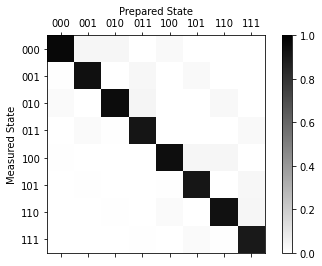

In [27]:
# custom discriminator

print("readout_fidelity:", meas_fitter.readout_fidelity())
print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

readout_fidelity: 0.905640625
cal_matrix: [[9.5071875e-01 5.3687500e-02 4.0906250e-02 2.1250000e-03 4.3875000e-02
  2.4687500e-03 2.1250000e-03 6.2500000e-05]
 [2.1406250e-02 9.1903125e-01 1.1875000e-03 3.9062500e-02 6.5625000e-04
  4.1656250e-02 3.1250000e-05 2.4375000e-03]
 [7.0312500e-03 4.0625000e-04 9.1706250e-01 5.5718750e-02 2.8125000e-04
  0.0000000e+00 4.0375000e-02 2.2812500e-03]
 [3.1250000e-04 6.3437500e-03 2.1531250e-02 8.8306250e-01 0.0000000e+00
  3.7500000e-04 8.1250000e-04 4.0468750e-02]
 [1.9718750e-02 8.7500000e-04 1.0000000e-03 9.3750000e-05 9.2381250e-01
  5.1750000e-02 3.8125000e-02 2.2812500e-03]
 [5.6250000e-04 1.9468750e-02 3.1250000e-05 6.2500000e-04 2.3812500e-02
  8.9637500e-01 1.1250000e-03 4.0781250e-02]
 [2.1875000e-04 3.1250000e-05 1.7937500e-02 9.3750000e-04 7.3125000e-03
  5.6250000e-04 8.9740625e-01 5.4031250e-02]
 [3.1250000e-05 1.5625000e-04 3.4375000e-04 1.8375000e-02 2.5000000e-04
  6.8125000e-03 2.0000000e-02 8.5765625e-01]]


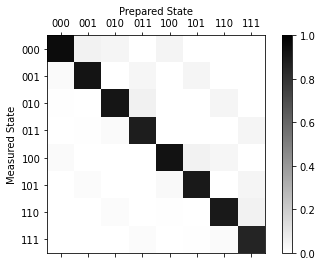

In [21]:
# no custom discriminator!

print("readout_fidelity:", meas_fitter.readout_fidelity())
print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [10]:
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    # print(tomo_fitter.data)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
 
    return fid

In [11]:
def generate_zne_pattern(trotter_steps, noise):
    if noise > 3.01:
        raise NotImplementedError("noise higher than 3.01 is not yet implemented")
    circuits_in_11_patern = 2 # zne without noise has 2 circuits for every trotter steps (G01, G12)
    circuits_in_12_patern = 4 # zne with noise only applied to one ising circuit has 4 circuits (G01, Gd01, G01,G12)
    circuits_in_22_patern = 6 # zne with noise on both ising circuits has 6 circuits (G01, Gd01, G01, G12, Gd12, G12)

    for num_of_22_patterns in range(trotter_steps, -1, -1):
        zne_score = num_of_22_patterns*circuits_in_22_patern + (trotter_steps-num_of_22_patterns)*circuits_in_11_patern
        if noise > zne_score / (trotter_steps*circuits_in_11_patern):
            break
    # print("num_of_22_patterns", num_of_22_patterns)
    
    for num_of_12_patterns in range(trotter_steps, -1, -1):
        zne_score = num_of_12_patterns*circuits_in_12_patern + (trotter_steps-num_of_12_patterns-num_of_22_patterns)*circuits_in_11_patern + num_of_22_patterns*circuits_in_22_patern
        if noise > zne_score / (trotter_steps*circuits_in_11_patern):
            break
    # print("num_of_12_patterns", num_of_12_patterns)
    
    zne_pattern = [[1,1]]*trotter_steps
    steps = list(range(0, trotter_steps))
    for _ in range(0, num_of_22_patterns):
        rnd_step = random.randint(0, len(steps)-1)
        # print(rnd_step, len(steps))
        zne_pattern[steps[rnd_step]] = [2,2]
        steps.pop(rnd_step)
    for _ in range(0, num_of_12_patterns):
        rnd_step = random.randint(0, len(steps)-1)
        # print(rnd_step, len(steps))
        if random.random() > 0.5:
            zne_pattern[steps[rnd_step]] = [1,2]
        else:
            zne_pattern[steps[rnd_step]] = [2,1]
        steps.pop(rnd_step)

    return zne_pattern, num_of_12_patterns, num_of_22_patterns
        
    
zne_pattern_, _12, _22 = generate_zne_pattern(trotter_steps=7, noise=1.8)

# zne_pattern_

In [14]:
timestr = time.strftime("%Y%m%d-%H%M%S")

circuits = []
jobs = []

target_time = np.pi
calibrated_ = False
meas_calibrated_ = False
dd_pattern_ = "CP_n4"

steps_ = 11

# experiments = \
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.00)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.43)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.86)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.29)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.72)[0], "comment": ""}] +\
#     [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=3.01)[0], "comment": ""}]
experiments = \
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.00)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.15)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.43)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.58)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=1.86)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.01)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.29)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.43)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.72)[0], "comment": ""}] +\
    [{'steps': steps_, "circ_type": "rzx", "calibrated": calibrated_, "calibrated_meas": meas_calibrated_, "dd": dd_pattern_, "zne_pattern": generate_zne_pattern(trotter_steps=steps_, noise=2.86)[0], "comment": ""}]

# @background
def execute_circuit(target_time):
    circuits = []
    inst_map_ = None
    for idx, exp in enumerate(experiments):
        print(exp)
        qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
        circuits.extend(qc)

    schedule_qc = schedule(circuits, backend, inst_map=inst_map_, method='alap')
    print("schedules prepared")

    if exp['calibrated_meas']:
        schedule_qc = add_measurement_cal(schedule_qc, discriminators=discriminators)
        print("measurement calibration added")
    if exp['dd'] is not None:
        schedule_qc = add_dd(schedule_qc, pattern=exp['dd'])
        print("dynamic decoupling added")
    
    job = execute(schedule_qc, backend, meas_level=2, shots=16000, optimization_level=0)
    print("circuit schedule for execution")
    print(str(job.job_id()) + "\t" + str(experiments) + "\n")
    if not os.path.exists("./benchmarks"):
        os.makedirs("./benchmarks")
    with open("./benchmarks/" + "ZNE_single_Jackarta_real_benchmark" + timestr + ".tsv", 'a+') as f:
        f.write(str(job.job_id()) + "\t" + str(experiments) + "\n")
    
    # job.wait_for_final_state()
    # job_monitor(job)
    return job, circuits, schedule_qc

jobs, circuits, _ = execute_circuit(target_time)

{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}
{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}
{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}
{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}
{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], 

  0%|          | 0/270 [00:00<?, ?it/s]

dynamic decoupling added
circuit schedule for execution
62494b40e978c76a95fb1f1b	[{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': Fa

### Measurement filter restore

  0%|          | 0/8 [00:00<?, ?it/s]

readout_fidelity: 0.94116015625
cal_matrix: [[9.7518750e-01 2.8375000e-02 2.8125000e-02 7.8125000e-04 3.9125000e-02
  1.2812500e-03 1.0312500e-03 3.1250000e-05]
 [7.0000000e-03 9.5637500e-01 3.1250000e-04 2.6875000e-02 1.8750000e-04
  3.7468750e-02 3.1250000e-05 8.7500000e-04]
 [8.2187500e-03 3.7500000e-04 9.5784375e-01 3.1375000e-02 7.5000000e-04
  3.1250000e-05 3.5781250e-02 1.0937500e-03]
 [1.2500000e-04 8.0625000e-03 6.5000000e-03 9.3431250e-01 3.1250000e-05
  4.0625000e-04 2.5000000e-04 3.4625000e-02]
 [9.2500000e-03 1.8750000e-04 5.9375000e-04 0.0000000e+00 9.4353125e-01
  2.8312500e-02 2.7562500e-02 7.1875000e-04]
 [9.3750000e-05 6.6250000e-03 0.0000000e+00 3.7500000e-04 7.0937500e-03
  9.2368750e-01 2.8125000e-04 2.5656250e-02]
 [1.2500000e-04 0.0000000e+00 6.5312500e-03 2.8125000e-04 9.1875000e-03
  5.9375000e-04 9.2875000e-01 2.7406250e-02]
 [0.0000000e+00 0.0000000e+00 9.3750000e-05 6.0000000e-03 9.3750000e-05
  8.2187500e-03 6.3125000e-03 9.0959375e-01]]


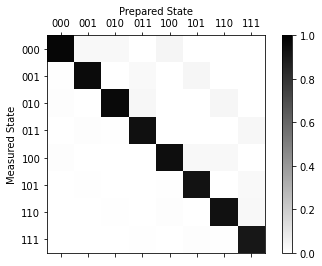

In [27]:
# restore custom discriminator measurement filter - 1 week after calibration
job_cal = backend.retrieve_job("6239f69f09995c20cf491eee")

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)
# job_cal = execute(meas_calibs_schedules, backend=backend, shots=32000)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

print("readout_fidelity:", meas_fitter.readout_fidelity())
print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

  0%|          | 0/8 [00:00<?, ?it/s]

readout_fidelity: 0.9317695312500001


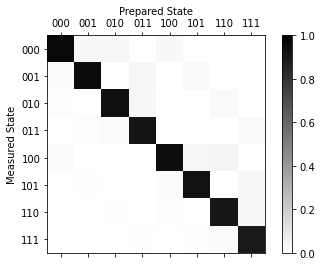

In [13]:
# restore custom discriminator measurement filter - 1 day after calibration
job_cal = backend.retrieve_job("62372f66e32b4293ceecc692")

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)
# job_cal = execute(meas_calibs_schedules, backend=backend, shots=32000)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

print("readout_fidelity:", meas_fitter.readout_fidelity())
# print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

  0%|          | 0/8 [00:00<?, ?it/s]

readout_fidelity: 0.9307460937500001


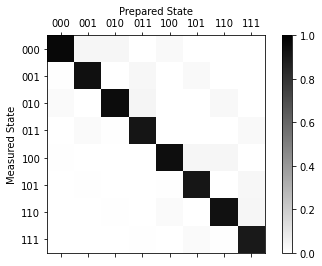

In [13]:
# restore custom discriminator measurement filter
job_cal = backend.retrieve_job("6236837219e689c3d1c7f97f")

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)
# job_cal = execute(meas_calibs_schedules, backend=backend, shots=32000)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

print("readout_fidelity:", meas_fitter.readout_fidelity())
# print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

### Ising simulation results

### RZX circuit changed

In [11]:
jobs = backend.retrieve_job("623fa429d97bffe87169520a")
experiments = [{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[2, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [24]:
from scipy.optimize import curve_fit
import copy

measurement_filter = False

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1

In [19]:
jobs = backend.retrieve_job("623fa0e619e6891fe4c81897")
experiments = [{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [20]:
from scipy.optimize import curve_fit
import copy

measurement_filter = False

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [2,

#### Long wait in pipeline

  0%|          | 0/8 [00:00<?, ?it/s]

readout_fidelity: 0.9307460937500001


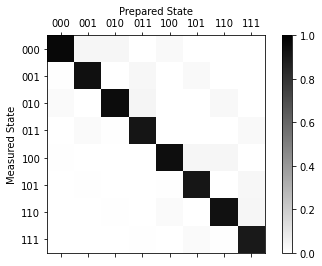

In [31]:
# restore custom discriminator measurement filter
job_cal = backend.retrieve_job("6236837219e689c3d1c7f97f")

from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

meas_calibs, state_labels = complete_meas_cal(qubit_list=[1,3,5], qr=7, circlabel='mcal')
meas_calibs_schedules = schedule(meas_calibs, backend, inst_map=inst_map_cal, method='alap')
meas_calibs_schedules = add_measurement_cal(meas_calibs_schedules, discriminators=discriminators)
# job_cal = execute(meas_calibs_schedules, backend=backend, shots=32000)
meas_fitter = CompleteMeasFitter(job_cal.result(), state_labels)

print("readout_fidelity:", meas_fitter.readout_fidelity())
# print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [32]:
# 62397663e32b423f81ecccd1	[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 2], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

jobs = backend.retrieve_job("62397663e32b423f81ecccd1")
experiments = [{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 2], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [34]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2

In [35]:
# 6237b4fd8293e91bc11e4c53	[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [1, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 1], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 1], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

jobs = backend.retrieve_job("6237b4fd8293e91bc11e4c53")
experiments = [{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [1, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 1], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 1], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [36]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1]

In [ ]:
6237a4c174de0ea22b859cfd	[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Uhrig_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

Error

In [37]:
# 623791c78293e9f5c11e4c0e	[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

jobs = backend.retrieve_job("623791c78293e9f5c11e4c0e")
experiments = [{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [38]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2

In [39]:
# 62377d8b538ebac4cc6102ec	[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

jobs = backend.retrieve_job("62377d8b538ebac4cc6102ec")
experiments = [{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [40]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2

In [ ]:
62377376ecc4130239b7060d	[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

Error

In [41]:
# 62376a4ae32b423728ecc711	[{'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

jobs = backend.retrieve_job("62376a4ae32b423728ecc711")
experiments = [{'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [42]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 1]], 'comment': ''}, {'steps': 12, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern'

In [73]:
jobs = backend.retrieve_job("623754a3d97bff37d8693572")
experiments = [{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1

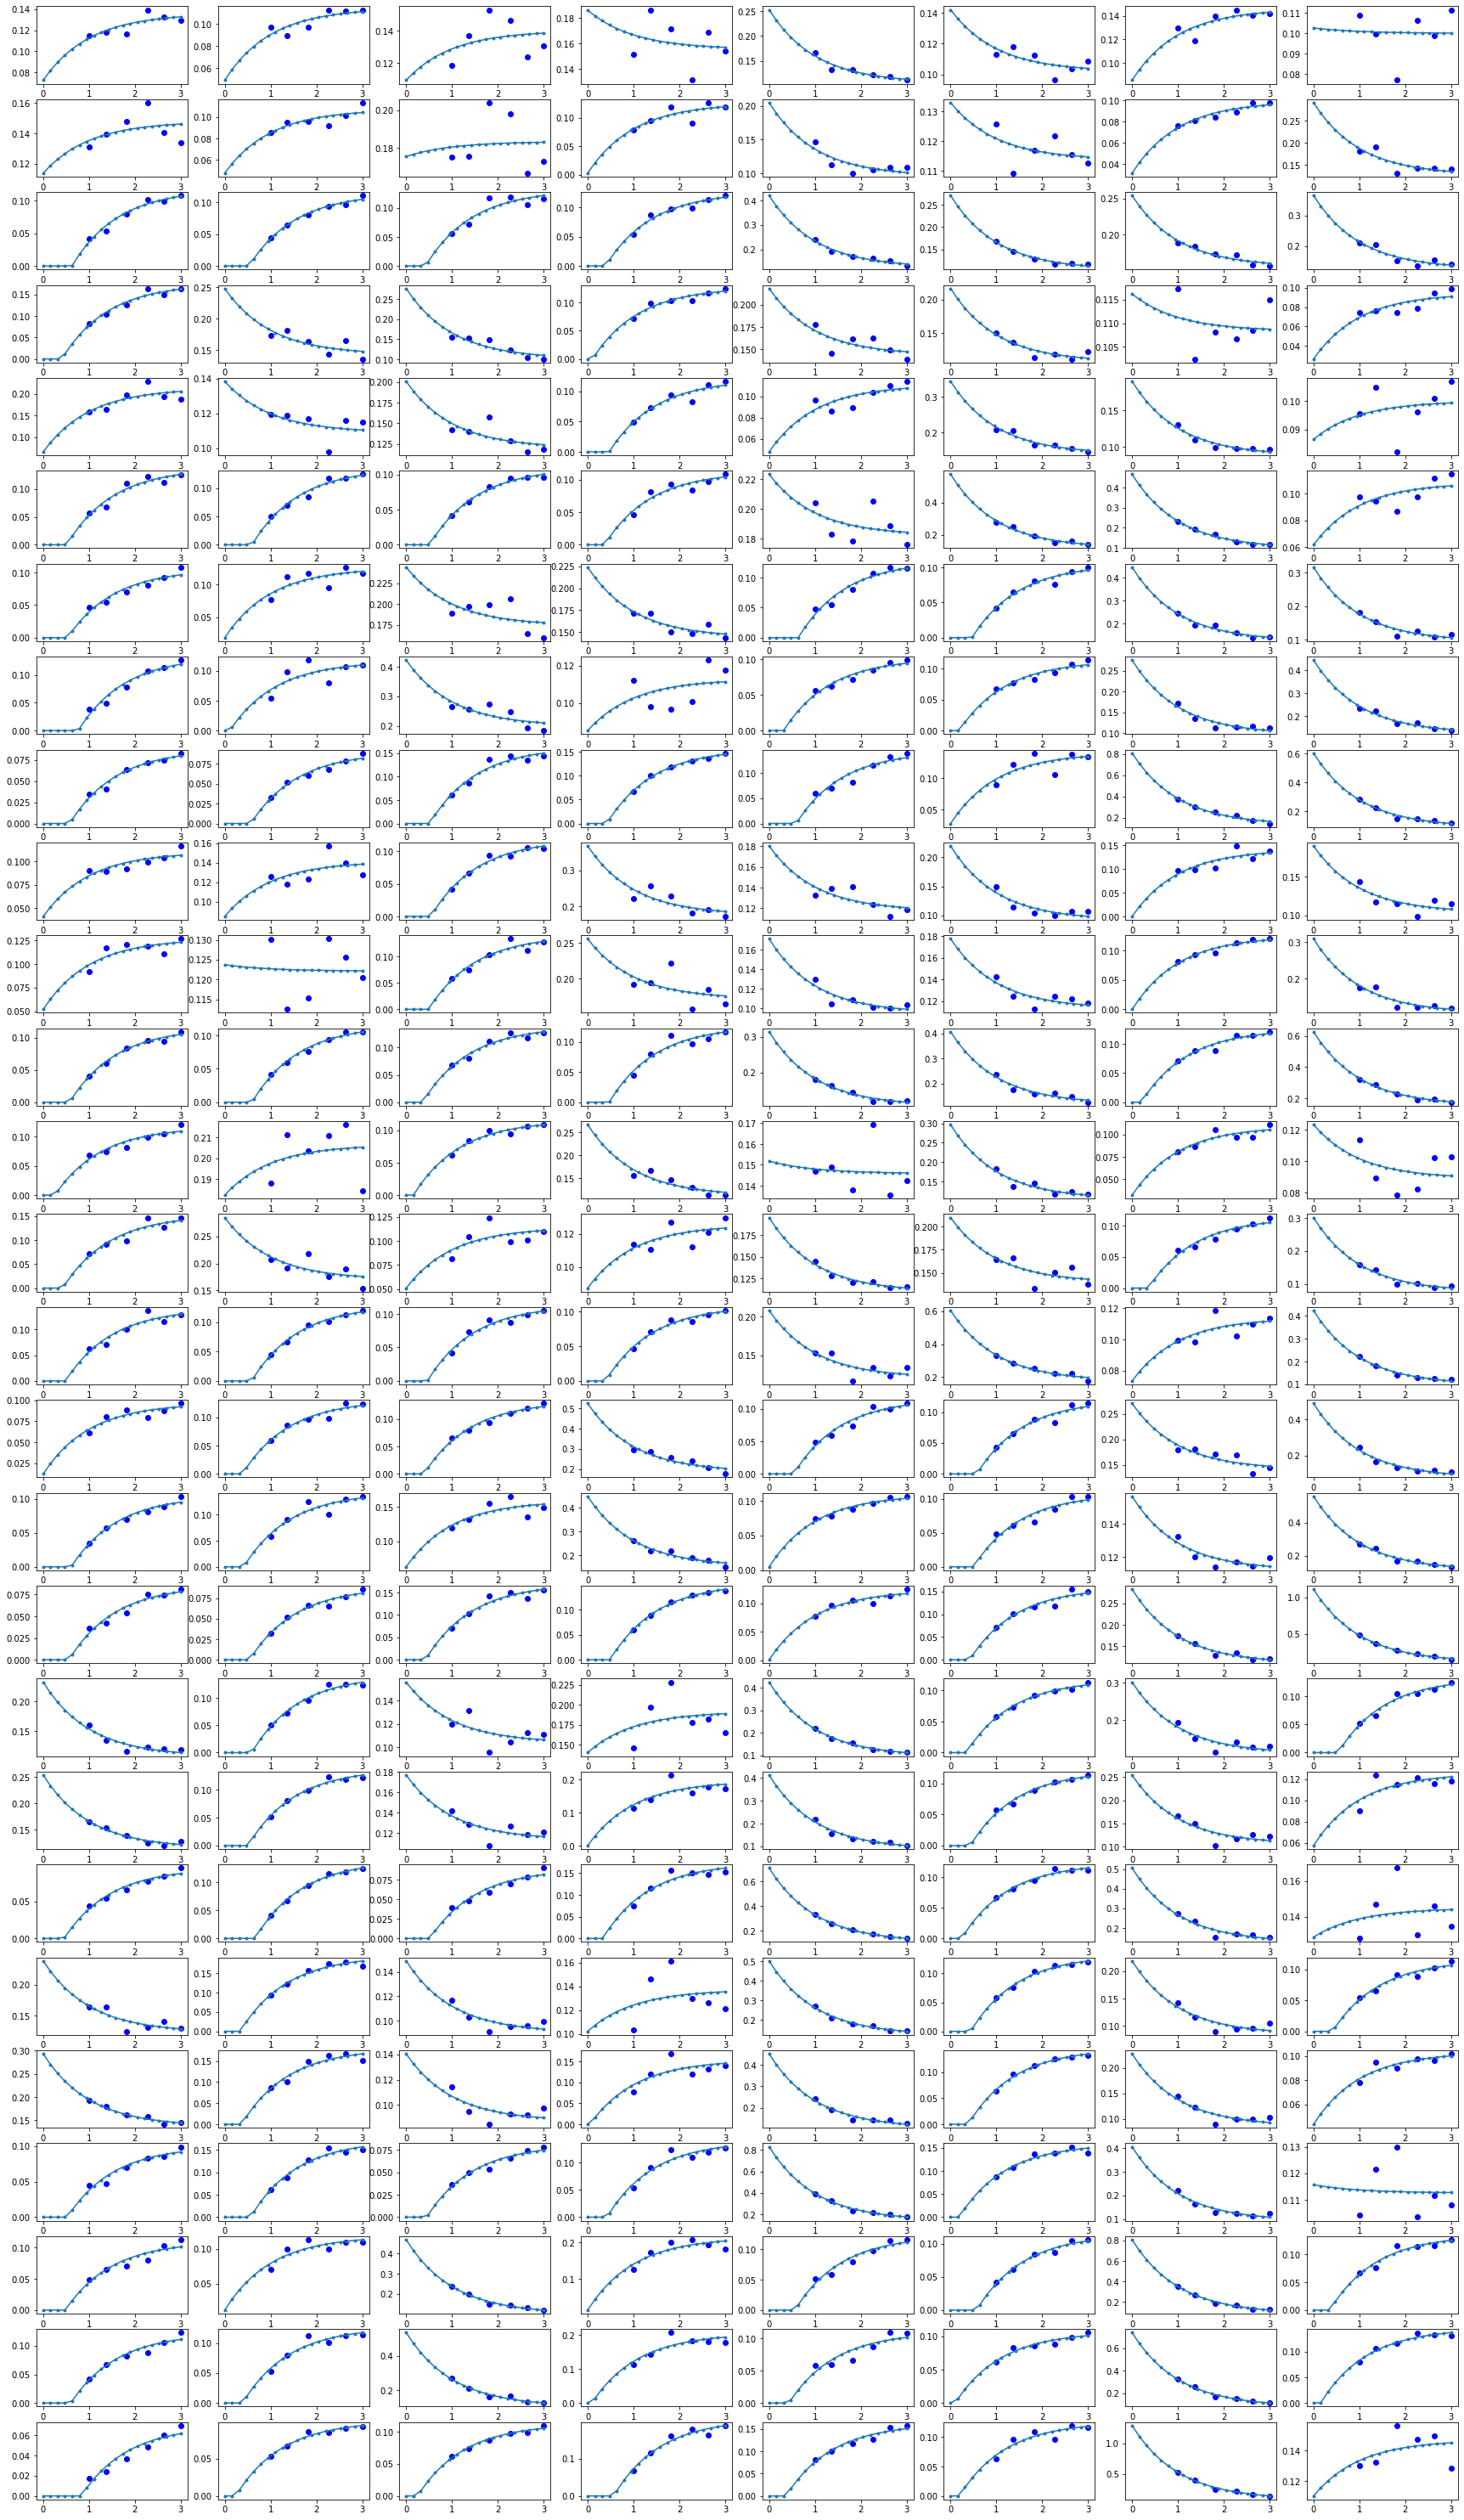

In [75]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = True

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        fit_data = [x if x>0 else 0 for x in fit_data]
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

In [25]:
# Single execution ZNE
from scipy.optimize import curve_fit
import copy

meas_filter_experiments_included = False
results_shift = 0
if meas_filter_experiments_included:
    results_shift = 2**3

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][results_shift:]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

# get the job results for the first 27 circuits which will be the real ising simulation without any zne noise scale
unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
# unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][results_shift:num_tomo_circ+results_shift]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

mitigated_results = meas_filter.apply(jobs.result()) # <-------------------------------------- apply measurement_filter
print(experiments)

meas_filter_result = copy.deepcopy(mitigated_results)
meas_filter_result_dict = meas_filter_result.to_dict()
meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][results_shift:num_tomo_circ+results_shift]
meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            # print(experiments[idx])
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            zne_noise = 1.0
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            try:
                zne_noise = sum(zne_coef) / len(zne_coef)
            except:
                pass
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                # expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx + results_shift][qubits_state] / shots  # 2**3 -> first 8 results are from measurement filter
                expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx + results_shift][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            # print(zne_noise, expected_state)
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        # print(x, y)
        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts #if zne_counts >= 0 else 0

    # normalize the results
    min_ = min([exp_results[key] for key in exp_results])
    for key in exp_results:
        exp_results[key] -= min_
    sum_ = sum([exp_results[key] for key in exp_results])
    for key in exp_results:
        exp_results[key] = exp_results[key]/sum_ * shots
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx + results_shift].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    # print(tomo_fitter.data)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    
    fid_mit = fid
    return fid, fid_mit

fid, fid_mit = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidality with zne:", fid)
fid, fid_mit = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidality w/o zne:", fid)
fid, fid_mit = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
print("fidality w/o zne with meas filter:", fid)

[{'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 11, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1

In [45]:
jobs = backend.retrieve_job("62373d4209995c28eb491671")
experiments = [{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [46]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2

In [56]:
jobs = backend.retrieve_job("62372a0819e6895e55c7fb8c")
experiments = [{'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [57]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps':

In [58]:
jobs = backend.retrieve_job("623723048293e9ba701e4b24")
experiments = [{'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [59]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [2, 1], [1, 1], [1, 1], [2, 2]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[1, 1], [2, 1], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 9, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n4', 'zne_pattern': [[2, 2], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 1]], 'comment': ''}, {'steps':

In [60]:
jobs = backend.retrieve_job("6236a195ecc4138876b703c4")

experiments = [{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 1], [1, 1], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)


In [61]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2

In [62]:
jobs = backend.retrieve_job("623698f98293e938331e495d")

experiments = [{'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [1, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)


In [63]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[1, 1], [2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': True, 'calibrated_meas': True, 'dd': 'CP_n2', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [1, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': Tr

In [64]:
jobs = backend.retrieve_job("62359aa209995ca41f49114f")

experiments = [{'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [1, 1], [1, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)


readout_fidelity: 0.89098046875
cal_matrix: [[9.3087500e-01 5.0875000e-02 4.1656250e-02 2.4687500e-03 5.4406250e-02
  3.2187500e-03 2.6875000e-03 3.1250000e-04]
 [2.6062500e-02 9.0593750e-01 7.5000000e-04 4.1968750e-02 1.7812500e-03
  5.3906250e-02 6.2500000e-05 2.8437500e-03]
 [1.2562500e-02 9.3750000e-04 9.0446875e-01 5.1281250e-02 8.4375000e-04
  3.1250000e-05 5.4843750e-02 3.2500000e-03]
 [3.1250000e-04 1.3250000e-02 2.2406250e-02 8.7418750e-01 3.1250000e-05
  1.0312500e-03 1.2812500e-03 5.1531250e-02]
 [2.8968750e-02 1.4062500e-03 1.3437500e-03 1.5625000e-04 9.0415625e-01
  4.9593750e-02 4.0187500e-02 2.5000000e-03]
 [8.1250000e-04 2.7218750e-02 0.0000000e+00 1.3125000e-03 2.4593750e-02
  8.7950000e-01 1.0000000e-03 3.8406250e-02]
 [4.0625000e-04 0.0000000e+00 2.8750000e-02 2.1875000e-03 1.3875000e-02
  6.2500000e-04 8.7775000e-01 5.0187500e-02]
 [0.0000000e+00 3.7500000e-04 6.2500000e-04 2.6437500e-02 3.1250000e-04
  1.2093750e-02 2.2187500e-02 8.5096875e-01]]


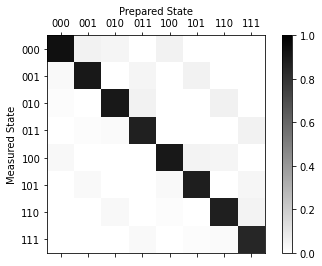

In [17]:
meas_calibs = copy.deepcopy(jobs.result())
meas_calibs_dict = meas_calibs.to_dict()
meas_calibs_dict['results'] = meas_calibs_dict['results'][0:2**3]
meas_calibs = meas_calibs.from_dict(meas_calibs_dict)

meas_fitter = CompleteMeasFitter(meas_calibs, state_labels)

print("readout_fidelity:", meas_fitter.readout_fidelity())
print("cal_matrix:", meas_fitter.cal_matrix)
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter

In [65]:
from scipy.optimize import curve_fit
import copy

measurement_filter = True

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [1, 1], [1, 1]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 10, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], 

In [66]:
jobs = backend.retrieve_job("623532018293e9650b1e4519")

experiments = [{'steps': 8, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [1, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [1, 1]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 8, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [71]:
from scipy.optimize import curve_fit
import copy

measurement_filter = False

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 1]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated

In [68]:
# 7 trotter steps one ZNE run
jobs = backend.retrieve_job("6235292e19e689abd6c7f562")

experiments = [{'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 1]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]], 'comment': ''}]

circuits = []
for idx, exp in enumerate(experiments):
    target_time = np.pi
    qc, inst_map_ = ising_sim(trotter_steps=exp['steps'], target_time=target_time, optimization_level=0, circ_type=exp["circ_type"], calibrated=exp['calibrated'], zne_pattern=exp["zne_pattern"])
    circuits.extend(qc)

In [70]:
from scipy.optimize import curve_fit
import copy

measurement_filter = False

zne_fit_func = lambda x, A, B: A*np.exp(-x)+B

num_tomo_circ = 3**3 # state tomography requires 3^qubits circuits

display_fig = False

if display_fig:
    fig, axs = plt.subplots(num_tomo_circ, 2**3, figsize=(30, num_tomo_circ*2))

zne_result = copy.deepcopy(jobs.result())
zne_result_dict = zne_result.to_dict()
zne_result_dict['results'] = zne_result.to_dict()['results'][0:num_tomo_circ]
zne_result = zne_result.from_dict(zne_result_dict)

circuit_without_noise_idx = 0

unmittigated_result = copy.deepcopy(jobs.result())
unmittigated_result_dict = unmittigated_result.to_dict()
unmittigated_result_dict['results'] = unmittigated_result.to_dict()['results'][0:num_tomo_circ]
unmittigated_result = unmittigated_result.from_dict(unmittigated_result_dict)

if measurement_filter:
    mitigated_results = meas_filter.apply(jobs.result())

    meas_filter_result = copy.deepcopy(mitigated_results)
    meas_filter_result_dict = meas_filter_result.to_dict()
    meas_filter_result_dict['results'] = meas_filter_result.to_dict()['results'][0:num_tomo_circ]
    meas_filter_result = meas_filter_result.from_dict(meas_filter_result_dict)
    
print(experiments)

for tomo_circ_idx in range(0, num_tomo_circ):
    # print(tomo_circ_idx)
    exp_results = {}
    for qubits_state in jobs.result().get_counts()[-1]:
        # print(qubits_state)
        x = []
        y = []

        exp_results[qubits_state] = 0
        shots = jobs.result().results[-1].shots # assuming that all circuits were run with the same shots number

        for idx, exp in enumerate(experiments): 
            zne_pattern = list(np.array(exp["zne_pattern"]).flat)
            zne_coef = [(x-1)*2+1 for x in zne_pattern] # (X-1)*2 + 1 => to get the odd numbers
            
            if display_fig:
                ax = axs[tomo_circ_idx][int(qubits_state,2)]
            
            zne_noise = sum(zne_coef) / len(zne_coef)
            if zne_noise == 1.0:
                circuit_without_noise_idx = idx
            
            expected_state = 0
            try:
                if measurement_filter:
                    expected_state = mitigated_results.get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
                else:
                    expected_state = jobs.result().get_counts()[idx*num_tomo_circ + tomo_circ_idx][qubits_state] / shots
            except (AttributeError, KeyError): # in case job is None, or No qubit state in the results
                pass
            if display_fig:
                ax.scatter(zne_noise, expected_state, color="blue")
            x.append(zne_noise)
            y.append(expected_state)

        fitparams, _ = curve_fit(zne_fit_func, x, y, maxfev=100000)
        
        fit_data = zne_fit_func(np.linspace(0, 3, 20), *fitparams)
        if display_fig:
            ax.plot(np.linspace(0, 3, 20), fit_data, marker='.')
        
        zne_counts = int(fit_data[0]*shots)
        exp_results[qubits_state] = zne_counts if zne_counts >= 0 else 0
    
    for key in sorted(exp_results):
        result_dict = zne_result.results[tomo_circ_idx].to_dict()
        result_dict['data']['counts']['0x'+str(int(key,2))] = exp_results[key]
        zne_result.results[tomo_circ_idx] = zne_result.results[tomo_circ_idx].from_dict(result_dict)

print('zne_result:', zne_result.get_counts()[-1])
print('w/o zne results:', unmittigated_result.get_counts()[-1])

fid = state_tomo(zne_result, circuits[0:num_tomo_circ])
print("fidelity with zne:", fid)
fid = state_tomo(unmittigated_result, circuits[0:num_tomo_circ])
print("fidelity w/o zne:", fid)
if measurement_filter:
    fid = state_tomo(meas_filter_result, circuits[0:num_tomo_circ])
    print("fidelity w/o zne with meas filter:", fid)

[{'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [1, 1], [2, 1]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[1, 1], [1, 1], [1, 1], [2, 2], [1, 1], [2, 2], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 1], [1, 1], [2, 2], [2, 2], [1, 1], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated': False, 'calibrated_meas': False, 'dd': 'Walsh_Paley5', 'zne_pattern': [[2, 2], [2, 2], [2, 2], [1, 1], [2, 2], [2, 2], [2, 2]], 'comment': ''}, {'steps': 7, 'circ_type': 'rzx', 'calibrated